# Lyft: Training with multi-mode confidence

![](http://www.l5kit.org/_images/av.jpg)
<cite>The image from L5Kit official document: <a href="http://www.l5kit.org/README.html">http://www.l5kit.org/README.html</a></cite>

Continued from the previous kernel:
 - [Lyft: Comprehensive guide to start competition](https://www.kaggle.com/corochann/lyft-comprehensive-guide-to-start-competition)
 - [Lyft: Deep into the l5kit library](https://www.kaggle.com/corochann/lyft-deep-into-the-l5kit-library)

In this kernel, I will run **pytorch CNN model training**. Especially, followings are new items to try:
 - Predict **multi-mode with confidence**: As written in [evaluation metric](https://www.kaggle.com/c/lyft-motion-prediction-autonomous-vehicles/overview/evaluation) page, we can predict **3 modes** of motion trajectory.
 - Training loss with **competition evaluation metric**
 - Use Training abstraction library **`pytorch-ignite` and `pytorch-pfn-extras`**.


[Update 2020/9/6]<br/>
Published prediction kernel: [Lyft: Prediction with multi-mode confidence](https://www.kaggle.com/corochann/lyft-prediction-with-multi-mode-confidence)<br/>
Try yourself how good score you can get using only single model without ensemble! :)

# Environment setup

 - Please add [pestipeti/lyft-l5kit-unofficial-fix](https://www.kaggle.com/pestipeti/lyft-l5kit-unofficial-fix) as utility script.
    - Official utility script "[philculliton/kaggle-l5kit](https://www.kaggle.com/mathurinache/kaggle-l5kit)" does not work with pytorch GPU.
 - Please add [lyft-config-files](https://www.kaggle.com/jpbremer/lyft-config-files) as dataset
 
See previous kernel [Lyft: Comprehensive guide to start competition](https://www.kaggle.com/corochann/lyft-comprehensive-guide-to-start-competition) for details.

In [14]:
# https://github.com/pfnet/pytorch-pfn-extras/releases/tag/v0.3.1
# !pip install pytorch-pfn-extras==0.6.1

In [15]:
import gc
import os
import time
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
# pd.set_option('max_columns', 50)


/tmp/ipykernel_992972/1331493952.py:17: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



In [16]:
import zarr

import l5kit
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable

from matplotlib import animation, rc
from IPython.display import HTML

rc('animation', html='jshtml')
print("l5kit version:", l5kit.__version__)

l5kit version: 1.5.0


In [17]:
import torch
from pathlib import Path

from torch.utils.data import DataLoader


## Function

To define loss function to calculate competition evaluation metric **in batch**.<br/>
It works with **pytorch tensor, so it is differentiable** and can be used for training Neural Network.

In [18]:
# --- Function utils ---
# Original code from https://github.com/lyft/l5kit/blob/20ab033c01610d711c3d36e1963ecec86e8b85b6/l5kit/l5kit/evaluation/metrics.py
import numpy as np

import torch
from torch import Tensor


def pytorch_neg_multi_log_likelihood_batch(
    gt: Tensor, pred: Tensor, confidences: Tensor, avails: Tensor
) -> Tensor:
    """
    Compute a negative log-likelihood for the multi-modal scenario.
    log-sum-exp trick is used here to avoid underflow and overflow, For more information about it see:
    https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations
    https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    https://leimao.github.io/blog/LogSumExp/
    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(modes)x(time)x(2D coords)
        confidences (Tensor): array of shape (bs)x(modes) with a confidence for each mode in each sample
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    assert len(pred.shape) == 4, f"expected 3D (MxTxC) array for pred, got {pred.shape}"
    batch_size, num_modes, future_len, num_coords = pred.shape
    # print(f"pred.shape : {pred.shape}")
    assert gt.shape == (batch_size, future_len, num_coords), f"wrong shape for gt, got {gt.shape}"
    assert confidences.shape == (batch_size, num_modes), f"expected 1D (Modes) array for gt, got {confidences.shape}"
    assert torch.allclose(torch.sum(confidences, dim=1), confidences.new_ones((batch_size,))), "confidences should sum to 1"
    assert avails.shape == (batch_size, future_len), f"expected 1D (Time) array for gt, got {avails.shape}"
    # assert all data are valid
    assert torch.isfinite(pred).all(), "invalid value found in pred"
    assert torch.isfinite(gt).all(), "invalid value found in gt"
    assert torch.isfinite(confidences).all(), "invalid value found in confidences"
    assert torch.isfinite(avails).all(), "invalid value found in avails"

    # convert to (batch_size, num_modes, future_len, num_coords)
    gt = torch.unsqueeze(gt, 1)  # add modes
    avails = avails[:, None, :, None]  # add modes and cords

    # error (batch_size, num_modes, future_len)
    error = torch.sum(((gt - pred) * avails) ** 2, dim=-1)  # reduce coords and use availability

    with np.errstate(divide="ignore"):  # when confidence is 0 log goes to -inf, but we're fine with it
        # error (batch_size, num_modes)
        error = torch.log(confidences) - 0.5 * torch.sum(error, dim=-1)  # reduce time

    # use max aggregator on modes for numerical stability
    # error (batch_size, num_modes)
    max_value, _ = error.max(dim=1, keepdim=True)  # error are negative at this point, so max() gives the minimum one
    error = -torch.log(torch.sum(torch.exp(error - max_value), dim=-1, keepdim=True)) - max_value  # reduce modes
    # print("error", error)
    return torch.mean(error)


def pytorch_neg_multi_log_likelihood_single(
    gt: Tensor, pred: Tensor, avails: Tensor
) -> Tensor:
    """

    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(time)x(2D coords)
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    # pred (bs)x(time)x(2D coords) --> (bs)x(mode=1)x(time)x(2D coords)
    # create confidence (bs)x(mode=1)
    batch_size, future_len, num_coords = pred.shape
    confidences = pred.new_ones((batch_size, 1))
    return pytorch_neg_multi_log_likelihood_batch(gt, pred.unsqueeze(1), confidences, avails)

## Model

pytorch model definition. Here model outputs both **multi-mode trajectory prediction & confidence of each trajectory**.

In [19]:
# --- Model utils ---
import torch
from torchvision.models import resnet18
from torch import nn
from typing import Dict



In [20]:
# --- Utils ---
import yaml


def save_yaml(filepath, content, width=120):
    with open(filepath, 'w') as f:
        yaml.dump(content, f, width=width)


def load_yaml(filepath):
    with open(filepath, 'r') as f:
        content = yaml.safe_load(f)
    return content


class DotDict(dict):
    """dot.notation access to dictionary attributes

    Refer: https://stackoverflow.com/questions/2352181/how-to-use-a-dot-to-access-members-of-dictionary/23689767#23689767
    """  # NOQA

    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    

## Configs

In [21]:
# --- Lyft configs ---
cfg = {
    'format_version': 4,
    'model_params': {
        'model_architecture': 'resnet50',
        'history_num_frames': 50,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
        'render_ego_history':True,
        'step_time':0.1
    },

    'raster_params': {
        'raster_size': [224, 224],
        # 'raster_size': [12, 12],
        'pixel_size': [0.5, 0.5],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map/aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5,

        'set_origin_to_bottom': True,
        'disable_traffic_light_faces':False
    },

    'train_data_loader': {
        'key': 'scenes/train.zarr',
        'batch_size': 12,
        'shuffle': False,
        'num_workers': 4
    },

    'valid_data_loader': {
        'key': 'scenes/validate.zarr',
        'batch_size': 32,
        'shuffle': False,
        'num_workers': 4
    },

    'train_params': {
        'max_num_steps': 10000,
        'checkpoint_every_n_steps': 5000,

        # 'eval_every_n_steps': -1
    }
}





In [22]:
flags_dict = {
    "debug": True,
    # --- Data configs ---
    "l5kit_data_folder": "/home/zhuhe/kaggle/input/lyft-motion-prediction-autonomous-vehicles",
    # --- Model configs ---
    "pred_mode": "multi",
    # --- Training configs ---
    "device": "cuda:0",
    "out_dir": "results/multi_train",
    "epoch": 2,
    "snapshot_freq": 50,
}

# Main script

Now finished defining all the util codes. Let's start writing main script to train the model!

## Loading data

Here we will only use the first dataset from the sample set. (sample.zarr data is used for visualization, please use train.zarr / validate.zarr / test.zarr for actual model training/validation/prediction.)<br/>
We're building a `LocalDataManager` object. This will resolve relative paths from the config using the `L5KIT_DATA_FOLDER` env variable we have just set.

In [23]:
flags = DotDict(flags_dict)
out_dir = Path(flags.out_dir)
os.makedirs(str(out_dir), exist_ok=True)
print(f"flags: {flags_dict}")
save_yaml(out_dir / 'flags.yaml', flags_dict)
save_yaml(out_dir / 'cfg.yaml', cfg)
debug = flags.debug



flags: {'debug': True, 'l5kit_data_folder': '/home/zhuhe/kaggle/input/lyft-motion-prediction-autonomous-vehicles', 'pred_mode': 'multi', 'device': 'cuda:0', 'out_dir': 'results/multi_train', 'epoch': 2, 'snapshot_freq': 50}


In [24]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = flags.l5kit_data_folder
dm = LocalDataManager(None)

print("Load dataset...")
train_cfg = cfg["train_data_loader"]
valid_cfg = cfg["valid_data_loader"]

# Rasterizer
rasterizer = build_rasterizer(cfg, dm)
train_path = "scenes/train.zarr" if debug else train_cfg["key"]
test_path = "scenes/test.zarr"
train_zarr = ChunkedDataset(dm.require(train_path)).open()
test_zarr = ChunkedDataset(dm.require(test_path)).open()
print("train_zarr", type(train_zarr))
print("test_zarr", type(test_zarr))
train_ego_dataset = EgoDataset(cfg, train_zarr, rasterizer)
train_agent_dataset = AgentDataset(cfg, train_zarr, rasterizer)
test_ego_dataset = EgoDataset(cfg, test_zarr, rasterizer)
test_agent_dataset = AgentDataset(cfg, test_zarr, rasterizer)

# valid_path = "scenes/sample.zarr" if debug else valid_cfg["key"]
# valid_zarr = ChunkedDataset(dm.require(valid_path)).open()
# print("valid_zarr", type(train_zarr))
# valid_agent_dataset = AgentDataset(cfg, valid_zarr, rasterizer)
# valid_dataset = TransformDataset(valid_agent_dataset, transform)


Load dataset...
train_zarr <class 'l5kit.data.zarr_dataset.ChunkedDataset'>
test_zarr <class 'l5kit.data.zarr_dataset.ChunkedDataset'>


In [25]:
def get_distance(centroid1, centroid2):
    return np.sqrt(np.square(centroid1[0]-centroid2[0]) + np.square(centroid1[1]-centroid2[1]))
# def change_all_list_to_ndarray(dic_in):

def transform_one_scene_dataset(scene_ego_dataset, scene_agent_dataset, debug: False):
    def add_element_into(ele_dict, ele):
        temp_x = []

        temp_x.extend(ele["history_positions"].flatten())
        temp_x.extend(ele["curr_speed"].flatten())
        temp_x.extend((ele["history_positions"][1:-1] - ele["history_positions"][0:-2]).flatten())
        temp_x.extend(ele["history_yaws"].flatten())
        # temp_x.extend(ele["history_availabilities"].flatten()) # 这个暂时不想要了
        ele_dict["x"].append(temp_x)
        if len(ele_dict["index"])== 0:
            cur_index = 0
        else:
            cur_index = ele_dict["index"][-1] + 1
        for i in range(0,cur_index):
            ele_dict["edge_attr"].append(get_distance(ele["centroid"], ele_dict["centroid"][i])) # 双向图
            ele_dict["edge_index"][0].append(i)
            ele_dict["edge_index"][1].append(cur_index)
            ele_dict["edge_attr"].append(get_distance(ele["centroid"], ele_dict["centroid"][i]))
            ele_dict["edge_index"][1].append(i)
            ele_dict["edge_index"][0].append(cur_index)
        ele_dict["target_positions"].append(ele["target_positions"])
        ele_dict["target_availabilities"].append(ele["target_availabilities"])
        ele_dict["centroid"].append(ele["centroid"])  # 这个元素是为了建图方便
        ele_dict["index"].append(cur_index)  # 这个元素是为了建图方便

    return_np = [] # 这个的长度应该是247或者248的样子，并且这个就是frame_index

    for ele in scene_ego_dataset:
        ele_dict = {}
        for name in ["x","edge_index","edge_attr","centroid","index","target_positions","target_availabilities"]:
            if name == "edge_index":
                ele_dict[name] = [[],[]]
            else:
                ele_dict[name] = []
        add_element_into(ele_dict,ele)
        return_np.append(ele_dict)
    if debug:
        print(f"len(return_np) : {len(return_np)}")
    for ele in scene_agent_dataset:
        curr_frame_index = ele["frame_index"]
        if debug:
            print(ele["frame_index"])
        cur_dict = return_np[curr_frame_index]
        add_element_into(cur_dict, ele)

    for ele in return_np:
        for key_ in ele.keys():
            ele[key_] = np.array(ele[key_])

        ele["x"] = torch.tensor(ele["x"])
        ele["edge_index"] = torch.tensor(ele["edge_index"],dtype=torch.long)
        ele["edge_attr"] = torch.tensor(ele["edge_attr"])
        ele["target_positions"] = torch.tensor(ele["target_positions"])
        ele["target_availabilities"] = torch.tensor(ele["target_availabilities"])

    return return_np

## Prepare model & optimizer

In [26]:

import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, whether_dropout= False):
        # TODO: Implement this function that initializes self.convs,
        # self.bns, and self.softmax.

        super(GCN, self).__init__()

        # A list of GCNConv layers
        self.convs = None

        # A list of 1D batch normalization layers
        self.bns = None

        # The log softmax layer
        self.softmax = None
        self.dropout = dropout

        self.convs = torch.nn.ModuleList()

        for i in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        self.bns=torch.nn.ModuleList([torch.nn.BatchNorm1d(hidden_dim) for i in range(num_layers-1)])
        self.convs.append(GCNConv(input_dim, hidden_dim))
        self.whether_dropout = whether_dropout
        self.output_fc = torch.nn.Linear(in_features=hidden_dim,out_features=output_dim)
        self.input_fc = torch.nn.Linear(in_features=input_dim,out_features=hidden_dim) # 输入输出的至关重要




    def forward(self, batch_data):
        out = None
        x = batch_data.x
        x = self.input_fc(x)
        for layer in range(len(self.convs)-1):  #layer：层数
            x=self.convs[layer](x,batch_data.edge_index,batch_data.edge_attr).to(torch.float)   #叠GCNConv
            x=self.bns[layer](x) #先bns再relu
            # x= x.to(torch.float)# 这个是因为他这的输出搞成了float64,导致大家数据形式不兼容
            x=F.relu(x)  #叠relu,这个不会导致数据被转化成float,
            if self.whether_dropout is True:
                x=F.dropout(x,self.dropout,self.training)  #叠dropout。这个self.dropout看下文是概率。
        #最后一层

        out=self.convs[-1](x,batch_data.edge_index,batch_data.edge_attr).to(torch.float)  #GCNVonv
        out = self.output_fc(out)
        return out




In [27]:
args = {
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_layers': 3,
    'hidden_dim': 512,
    'dropout': 0.3,
    'lr': 0.001,
    'epochs': 300,
    'train_scene_start': 600, # 这个该有多少，还要好好想想，因为我们存储的数据并不多，主要是egodataset的load速度那边被限制住了
    'train_scene_end': 700,
    'test_scene_start': 30,
    'test_scene_end': 50,
    'batch_size_gcn':512,
    'whether_dropout' : True,
}

In [28]:
#dict_keys(['frame_index', 'image', 'target_positions', 'target_yaws', 'target_velocities', 'target_availabilities', 'history_positions', 'history_yaws', 'history_velocities', 'history_availabilities', 'world_to_image', 'raster_from_agent', 'raster_from_world', 'agent_from_world', 'world_from_agent', 'centroid', 'yaw', 'extent', 'history_extents', 'future_extents', 'curr_speed', 'scene_index', 'host_id', 'timestamp', 'track_id'])

In [41]:
from l5kit.visualization import PREDICTED_POINTS_COLOR

def visualize_trajectory(dataset, index,whether_draw_pred = True, title="target_positions movement with draw_trajectory"):
    data = dataset[index]
    im = data["image"].transpose(1, 2, 0)

    im = dataset.rasterizer.to_rgb(im)

    target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
    # print(target_positions_pixels)
    if whether_draw_pred is True:
        draw_trajectory(im, target_positions_pixels, yaws=data["target_yaws"], rgb_color=TARGET_POINTS_COLOR)
    # draw_trajectory(im, target_positions_pixels, yaws=data["target_yaws"], rgb_color=PREDICTED_POINTS_COLOR)
    # 这个yaw只会影响一点点.拖拽是历史信息

    plt.title(title)
    plt.imshow(im[::-1])
    plt.show()


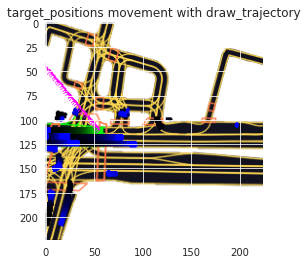

In [51]:
visualize_trajectory(train_agent_dataset,17700,whether_draw_pred=True)

In [30]:

from IPython.display import display, clear_output
import PIL

def animation_self(dataset,scene_idx):
    indexes = dataset.get_scene_indices(scene_idx)
    images = []

    for idx in indexes:
        data = dataset[idx]

        im = data["image"].transpose(1, 2, 0)
        im = dataset.rasterizer.to_rgb(im)
        target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
        center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
        draw_trajectory(im, target_positions_pixels, yaws =  data["target_yaws"], rgb_color=TARGET_POINTS_COLOR)
        clear_output(wait=True)
        images.append(PIL.Image.fromarray(im[::-1]))
    return images
    # From https://www.kaggle.com/jpbremer/lyft-scene-visualisations by @jpbremer




In [31]:
import time
time1 = time.time()
scene_ego_dataset = train_ego_dataset.get_scene_dataset(60)
time2 = time.time()
scene_agent_dataset = train_agent_dataset.get_scene_dataset(60)
time3 = time.time()
frame_dic_array = transform_one_scene_dataset(scene_ego_dataset,scene_agent_dataset,debug=False)
# 主要是这个非常慢
time4 = time.time()
#
print(f'time2-time1:{time2-time1}')
print(f'time3-time2:{time3-time2}')
print(f'time4-time3:{time4-time3}')


/home/zhuhe/anaconda3/envs/pytorch/lib/python3.9/site-packages/l5kit/data/zarr_dataset.py:213: RuntimeWarning:

zarr dataset path should end with .zarr (for now). Open will fail for this dataset!

/home/zhuhe/anaconda3/envs/pytorch/lib/python3.9/site-packages/l5kit/dataset/agent.py:139: RuntimeWarning:

you're running with a custom agents_mask



time2-time1:0.006999492645263672
time3-time2:0.008362054824829102
time4-time3:69.31926822662354


In [32]:
# indices = train_agent_dataset.get_scene_indices(60)
# # print(indices)
#
# for i in indices:
#     a= train_agent_dataset[i]["frame_index"]
#     b = train_agent_dataset[i]['target_positions']
# # for ele in train_agent_dataset[indices]:
#
# time2 = time.time()
# print(f"time2 - time1 :{time2 - time1}")
# 这样甚至慢了3倍，变到70s
# time1 = time.time()
# for ele in scene_agent_dataset:
#     a= ele["frame_index"]
# time2 = time.time()
# print(f"time2 - time1 :{time2 - time1}")
# 这样是24s,多读数据不会影响时间，只要你读取了一个数据就会影响时间

In [33]:
# cur_index = 0
# end_index = 2000
# time1 = time.time()
# for ele in train_agent_dataset:
#     a= ele["frame_index"]
#     cur_index = cur_index + 1
#     if cur_index>=end_index:
#         break
#
# time2 = time.time()
# print(time2-time1)这样也不会快

In [34]:
%%capture
def animate_solution(images):

    def animate(i):
        im.set_data(images[i])
        return (im,)

    fig, ax = plt.subplots()
    im = ax.imshow(images[0])
    def init():
        im.set_data(images[0])
        return (im,)

    return animation.FuncAnimation(fig, animate, init_func=init, frames=len(images), interval=60, blit=True)


# anim = animate_solution(animation_self(train_ego_dataset,101))


In [35]:

# HTML(anim.to_jshtml())

In [36]:
def draw_the_path(position_array_of_one_car, color = 'green', decimal_ = 1):
    eposolor = 1e-6
    assert position_array_of_one_car.shape[1] == 2 , "请输入二维坐标"
    the_avalable_index = len(position_array_of_one_car) - 1
    for i in range(1,len(position_array_of_one_car)- 1):
        if position_array_of_one_car[i][0] < eposolor and position_array_of_one_car[i][1] < eposolor:
            the_avalable_index = i
            break
    plt.figure(figsize=[7,7])

    lim = (max(int(np.max(np.array(position_array_of_one_car[:,0]))),int(np.max(np.array(position_array_of_one_car[:,1])))) //10) * 10
    plt.xlim(-lim,lim)
    plt.ylim(-lim,lim)
    x_real = np.round(position_array_of_one_car[:the_avalable_index,0], decimal_ )
    y_real = np.round(position_array_of_one_car[:the_avalable_index,1], decimal_ )
    plt.plot( x_real,y_real,color = color)
    plt.scatter( x_real,y_real ,color = color)

def draw_the_all_path(data_dic):
    draw_the_path(data_dic["history_positions"],color='blue')
    draw_the_path(data_dic["target_positions"],color='red')

In [37]:
from torch_geometric.data import Data
from torch_geometric.loader import  DataLoader
# 这个函数也非常快
def convert_framearray_to_dataloader(frame_dic_array):
    pyg_data_list = []
    for ele in frame_dic_array:
        pyg_data_list.append(Data(x = ele["x"],edge_index=ele["edge_index"],edge_attr=ele["edge_attr"],y=torch.cat([ele["target_positions"],torch.unsqueeze(ele["target_availabilities"],dim=-1)],dim = -1)))
    return DataLoader(pyg_data_list,batch_size=args['batch_size_gcn'])



In [38]:
from tqdm import tqdm,trange
def load_all_data_into_memory(ego_dataset,agent_dataset,start_index,end_index):
    return_array = []
    for index_ in trange(start_index,end_index):

        scene_ego_dataset = ego_dataset.get_scene_dataset(index_)
        scene_agent_dataset = agent_dataset.get_scene_dataset(index_)
        frame_dic_array = transform_one_scene_dataset(scene_ego_dataset,scene_agent_dataset,debug=False)
        dataloader = convert_framearray_to_dataloader(frame_dic_array)
        return_array.append(dataloader)
    return  return_array

def prepare_dataloader_array():
    train_dataloader = load_all_data_into_memory(train_ego_dataset,train_agent_dataset,args['train_scene_start'],args['train_scene_end'])
    test_dataloader = load_all_data_into_memory(test_ego_dataset,test_agent_dataset,args['test_scene_start'],args['test_scene_end'])
    return train_dataloader,test_dataloader


In [39]:
train_dataloader,test_dataloader = prepare_dataloader_array()

  4%|▍         | 4/100 [03:07<1:15:10, 46.99s/it]


KeyboardInterrupt: 

In [ ]:
def train_with_batch(model, device, data_loader, optimizer, loss_fn):
    model.train()
    loss = 0

    # for step, batch in enumerate(tqdm(data_loader, desc="Iteration")):
    for batch in data_loader:
        batch = batch.to(device)
        if batch.x.shape[0] == 1 or batch.batch[-1] == 0:
            pass
        else:
            optimizer.zero_grad()
            out=model(batch)
            train_output=out.view([-1,50,2]).to(device)
            train_label = batch.y[:,:,0:2]
            train_availabilities = torch.squeeze(batch.y[:,:,2],dim=-1)
            loss=loss_fn(train_label,train_output,train_availabilities)
            loss = loss / len(train_label) # 这里务必除以batch大小
            loss.backward()
            optimizer.step()

    return loss.item()



In [ ]:
@torch.no_grad()
def test_with_batch(model, device, data_loader, loss_fn):

    model.eval()
    y_true = []
    y_pred = []
    loss_array = []
    y_availabilities = []
    x_value = []

    # for step, batch in enumerate(tqdm(data_loader, desc="Iteration")):
    for batch in data_loader:
        batch = batch.to(device)
        if batch.x.shape[0] == 1 or batch.batch[-1] == 0:
            pass
        else:
            out=model(batch)

            train_output=out.view([-1,50,2]).to(device)
            train_label = batch.y[:,:,0:2]
            train_availabilities = torch.squeeze(batch.y[:,:,2],dim=-1)
            loss=loss_fn(train_label,train_output,train_availabilities)
            loss = loss
            y_true.append(train_label.detach().cpu())
            y_pred.append(train_output.detach().cpu())
            y_availabilities.append(train_availabilities.detach().cpu())
            history_x = batch.x
            x_value.append(history_x.detach().cpu())
            loss_array.append(loss.item())

    loss_array = np.array(loss_array)



    return y_true,y_pred,loss_array,y_availabilities,x_value

In [ ]:
import sys
print(len(train_dataloader))
# print(sys.getsizeof(train_dataloader[0]) / 1024 / 1024, 'MB')
# for i in trange(0,100):
#     print(i)

In [ ]:


input_dim = len(frame_dic_array[0]["x"][0])
model_gcn = GCN(input_dim=input_dim, hidden_dim=args["hidden_dim"], output_dim = cfg["model_params"]["future_num_frames"] * 2,num_layers=args["num_layers"],dropout=args["dropout"], whether_dropout=args["whether_dropout"])

model_gcn = model_gcn.to(device=args['device'])

print(model_gcn.eval())

optimizer = torch.optim.Adam(model_gcn.parameters(), lr=args["lr"])

In [ ]:

train_file = open('train_output.txt', 'w+',encoding = 'utf-8' )
test_file = open( 'test_output.txt', 'w+',encoding = 'utf-8' )
loss_each_epoch_train = []
loss_each_epoch_test = []

y_true_all = []
y_pred_all = []
y_availabilities_all = []
x_value_all = []
for epoch in trange(1, 1 + args["epochs"]):


    if epoch % 10 == 1:
        loss_list = []
        for test_scene_index in range(0,args['test_scene_end']-args['test_scene_start']):

            dataloader = test_dataloader[test_scene_index]
            y_true,y_pred,loss_array,y_availabilities,x_value = test_with_batch(model_gcn,args["device"],dataloader,pytorch_neg_multi_log_likelihood_single)
            loss_list.append(loss_array.mean())
            if epoch > args["epochs"] - 18:
                y_true_all.append(y_true)
                y_pred_all.append(y_pred)
                y_availabilities_all.append(y_availabilities)
                x_value_all.append(x_value)
        loss_list = np.array(loss_list)
        test_file.write(str(loss_list.mean()))
        print("测试误差: " + str(loss_list.mean()))
        print("每个xy点预测误差" + str(loss_list.mean()/50))
        test_file.write("\n")
        loss_each_epoch_test.append(loss_list.mean())

    loss_this_epoch = 0

    for train_scene_index in range(0,args['train_scene_end']-args['train_scene_start']):

        dataloader = train_dataloader[train_scene_index]


        loss_each_frame = train_with_batch(model_gcn,args["device"],dataloader,optimizer,pytorch_neg_multi_log_likelihood_single)
        loss_this_scene = np.mean(np.array(loss_each_frame))
        loss_this_epoch = loss_this_epoch + loss_this_scene

    loss_each_epoch_train.append(loss_this_epoch/(args['train_scene_end']-args['train_scene_start']))
    train_file.write(str(loss_each_epoch_train[-1]))
    train_file.write("\n")
    if epoch % 10 == 1:
        print("每10轮训练误差: " + str(loss_each_epoch_train[-1]))



test_file.close()
train_file.close()
torch.save(model_gcn,"model_gcn_fc_2layer_fc_2022_10_22.pt")

In [ ]:
import pickle
file1 = open("y_true_all.pkl","wb")
pickle.dump(y_true_all, file1)
file2 = open("y_pred_all.pkl","wb")
pickle.dump(y_pred_all, file2)
file3 = open("y_availabilities_all.pkl","wb")
pickle.dump(y_availabilities_all, file3)
file4 = open("x_value_all.pkl","wb")
pickle.dump(x_value_all, file4)
file5 = open("loss_each_epoch_train.pkl","wb")
pickle.dump(loss_each_epoch_train, file5)
file6 = open("loss_each_epoch_test.pkl","wb")
pickle.dump(loss_each_epoch_test, file6)


In [ ]:
import numpy as np
import pickle
file_open1 = open("loss_each_epoch_train.pkl","rb")
loss_each_epoch_train = np.array(pickle.load(file_open1))
file_open2 = open("loss_each_epoch_test.pkl","rb")
loss_each_epoch_test = np.array(pickle.load(file_open2))

In [ ]:
# print(loss_each_epoch_train)# 每一轮平均每一个场景的损失
import matplotlib.pyplot as plt
def plot_loss(loss_list):
    plt.plot( np.arange(start=0,stop = len(loss_list)), loss_each_epoch_train)

loss_each_epoch_train = loss_each_epoch_train * np.array([256])
plot_loss(loss_each_epoch_train  )

In [ ]:
test_dataloader = load_all_data_into_memory(test_ego_dataset,test_agent_dataset,args['test_scene_start'],args['test_scene_end'])

In [ ]:
import torch
import pickle

model_gcn_load_5layer = torch.load("model_gcn_5layer_2022_10_21.pt")
model_gcn_load_3layer_fc = torch.load("model_gcn_3layer_2022_10_22.pt")


In [ ]:
loss_final_each_scene_train_5layer = []
loss_final_each_scene_train_3layer_fc = []
file_open3 = open("loss_baseline.pkl","rb")
loss_each_epoch_test_cnn = np.array(pickle.load(file_open3))
for test_scene_index in range(len(test_dataloader)):
    dataloader = test_dataloader[test_scene_index]
    y_true,y_pred,loss_array,y_availabilities,x_value = test_with_batch(model_gcn_load_5layer,args["device"],dataloader,pytorch_neg_multi_log_likelihood_single)
    loss_final_each_scene_train_5layer.append(loss_array)
    y_true,y_pred,loss_array,y_availabilities,x_value = test_with_batch(model_gcn_load_3layer_fc,args["device"],dataloader,pytorch_neg_multi_log_likelihood_single)
    loss_final_each_scene_train_3layer_fc.append(loss_array)

In [ ]:
file7 = open("loss_5layer.pkl","wb")
pickle.dump(loss_final_each_scene_train_5layer, file7)
file8 = open("loss_3layer.pkl","wb")
pickle.dump(loss_final_each_scene_train_3layer_fc, file8)

In [ ]:

loss_final_each_scene_train = np.array(loss_final_each_scene_train_3layer_fc).reshape(-1)
line1, = plt.plot( range(30,50),loss_final_each_scene_train,color = 'blue',label='GNN_3layer_1fc')
plt.scatter( range(30,50),loss_final_each_scene_train ,color = 'blue')

line2, = plt.plot( range(30,50),loss_each_epoch_test_cnn,color = 'red',label='resnet_18')
plt.scatter( range(30,50),loss_each_epoch_test_cnn,color = 'red')
plt.legend(handles=[line1, line2], labels=['GNN_3layer_1fc','resnet_18'], loc='best')
plt.show()
print(f"average loss of GNN_3layer_1fc:{np.mean(loss_final_each_scene_train)}")
print(f"resnet_18:{np.mean(loss_each_epoch_test_cnn)}")

In [ ]:
print(y_availabilities)

In [ ]:
print(y_availabilities[0].shape)

In [ ]:
print(y_true[0].shape)
for i in range(0,len(y_true[0]),5):
    plt.figure(figsize=[10,4])
    plt.subplot(121)
    # draw_the_path(y_true[0][i,:,:])
    plt.scatter(x = y_true[0][i,:,0], y = y_true[0][i,:,1])
    plt.subplot(122)
    # draw_the_path(y_pred[0][i,:,:])
    plt.scatter(x = y_pred[0][i,:,0], y = y_pred[0][i,:,1])
    plt.show()

In [ ]:
def plot_self(dataloader,scene_index, car_index):
    for batch in dataloader[scene_index]:
        x = np.array(batch.y[:][car_index][0])
        y = np.array(batch.y[:][car_index][0])
        print(x)
        print(y)
        plt.scatter(x, y)
        plt.show()


plot_self(train_dataloader,2,2)

You can obtrain training history results really easily by just accessing `LogReport` class, which is useful for managing a lot of experiments during kaggle competitions.

The history log and model's weight are saved by "extensions" (`LogReport` and `E.snapshot_object` respectively) easily, which is a benefit of using training abstration.

In [ ]:
# Let's see training results directory

!ls results/multi_train

# Items to try

This kernel shows demonstration run of the training (`debug=True`). You can try these things to see how the score changes at first
 - set debug=False to train with actual training dataset
 - change training hyperparameters (training epoch, change optimizer, scheduler learning rate etc...)
   - Especially, just training much longer time may improve the score.
 
To go further, these items may be nice to try:
 - Change the cnn model (now simple resnet18 is used as baseline modeling)
 - Training the model using full dataset: [lyft-full-training-set](https://www.kaggle.com/philculliton/lyft-full-training-set)
 - Write your own rasterizer to prepare input image as motivation explained in previous kernel.
 - Consider much better scheme to predict multi-trajectory
    - The model just predicts multiple trajectory at the same time in this kernel, but it is possible to collapse "trivial" solution where all trajectory converges to same. How to avoid this?

# Next to go

[Update 2020/9/6]<br/>
Published prediction kernel: [Lyft: Prediction with multi-mode confidence](https://www.kaggle.com/corochann/lyft-prediction-with-multi-mode-confidence)<br/>
Try yourself how good score you can get using only single model without ensemble! :)

To understand the competition in more detail, please refer my other kernels too.
 - [Lyft: Comprehensive guide to start competition](https://www.kaggle.com/corochann/lyft-comprehensive-guide-to-start-competition)
 - [Lyft: Deep into the l5kit library](https://www.kaggle.com/corochann/lyft-deep-into-the-l5kit-library)
 - [Save your time, submit without kernel inference](https://www.kaggle.com/corochann/save-your-time-submit-without-kernel-inference)
 - [Lyft: pytorch implementation of evaluation metric](https://www.kaggle.com/corochann/lyft-pytorch-implementation-of-evaluation-metric)

# Further reference

 - Paper of this Lyft Level 5 prediction dataset: [One Thousand and One Hours: Self-driving Motion Prediction Dataset](https://arxiv.org/abs/2006.14480)
 - [jpbremer/lyft-scene-visualisations](https://www.kaggle.com/jpbremer/lyft-scene-visualisations)

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>